# Modelo Random Forest

=== Modelo Random Forest para Predicción de VIH ===

[1/6] Cargando y procesando datos...

[3/6] Entrenando modelo Random Forest...

Optimizando hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Mejores parámetros encontrados:
n_estimators: 50
min_samples_split: 5
min_samples_leaf: 1
max_features: 0.8
max_depth: 30
bootstrap: False

[3.1/6] Importancia de características...


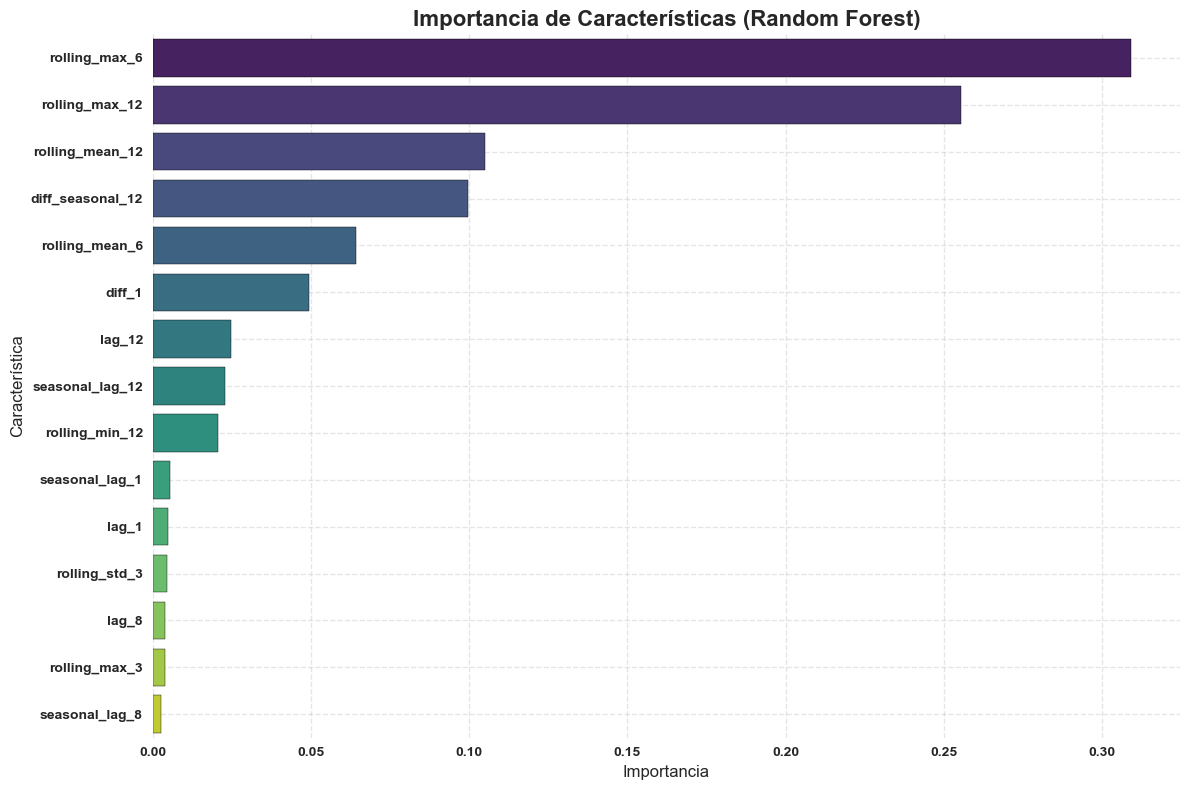


[3.2/6] Validación cruzada...

Resultados de Validación Cruzada:
RMSE: 21.38 ± 5.16
MAE: 17.96 ± 4.32
MAPE: 14.91 ± 4.75
R2: -0.05 ± 0.25

[4/6] Generando resultados finales...


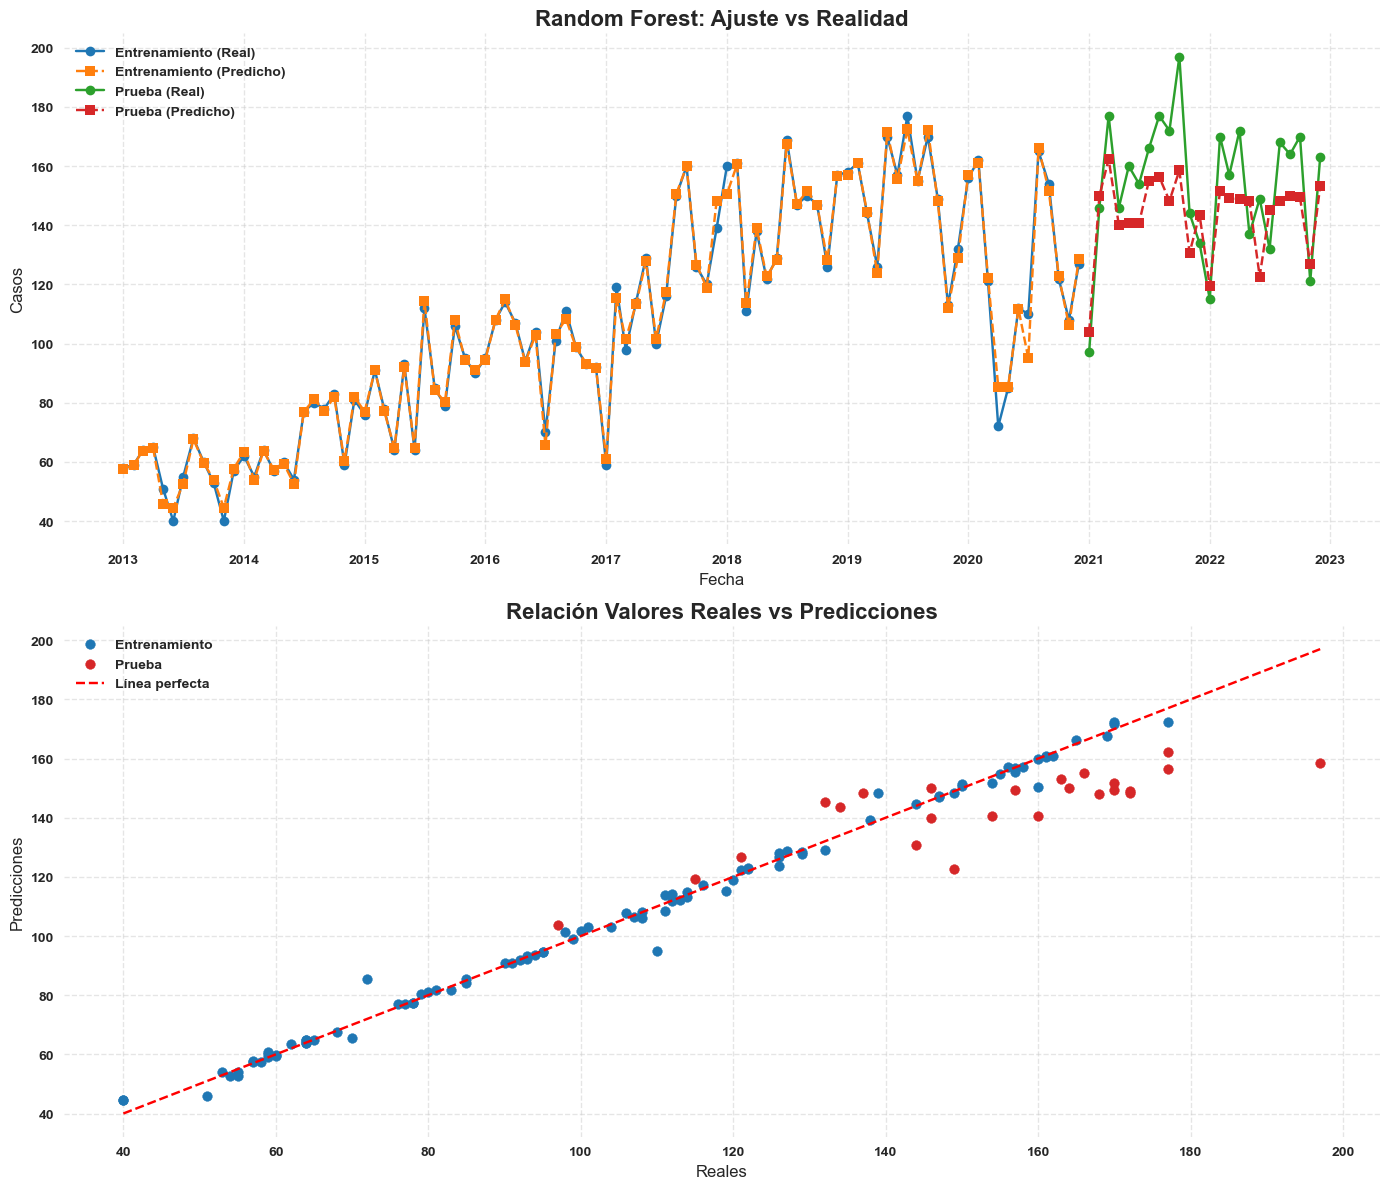


Análisis de residuos - Conjunto de Entrenamiento:


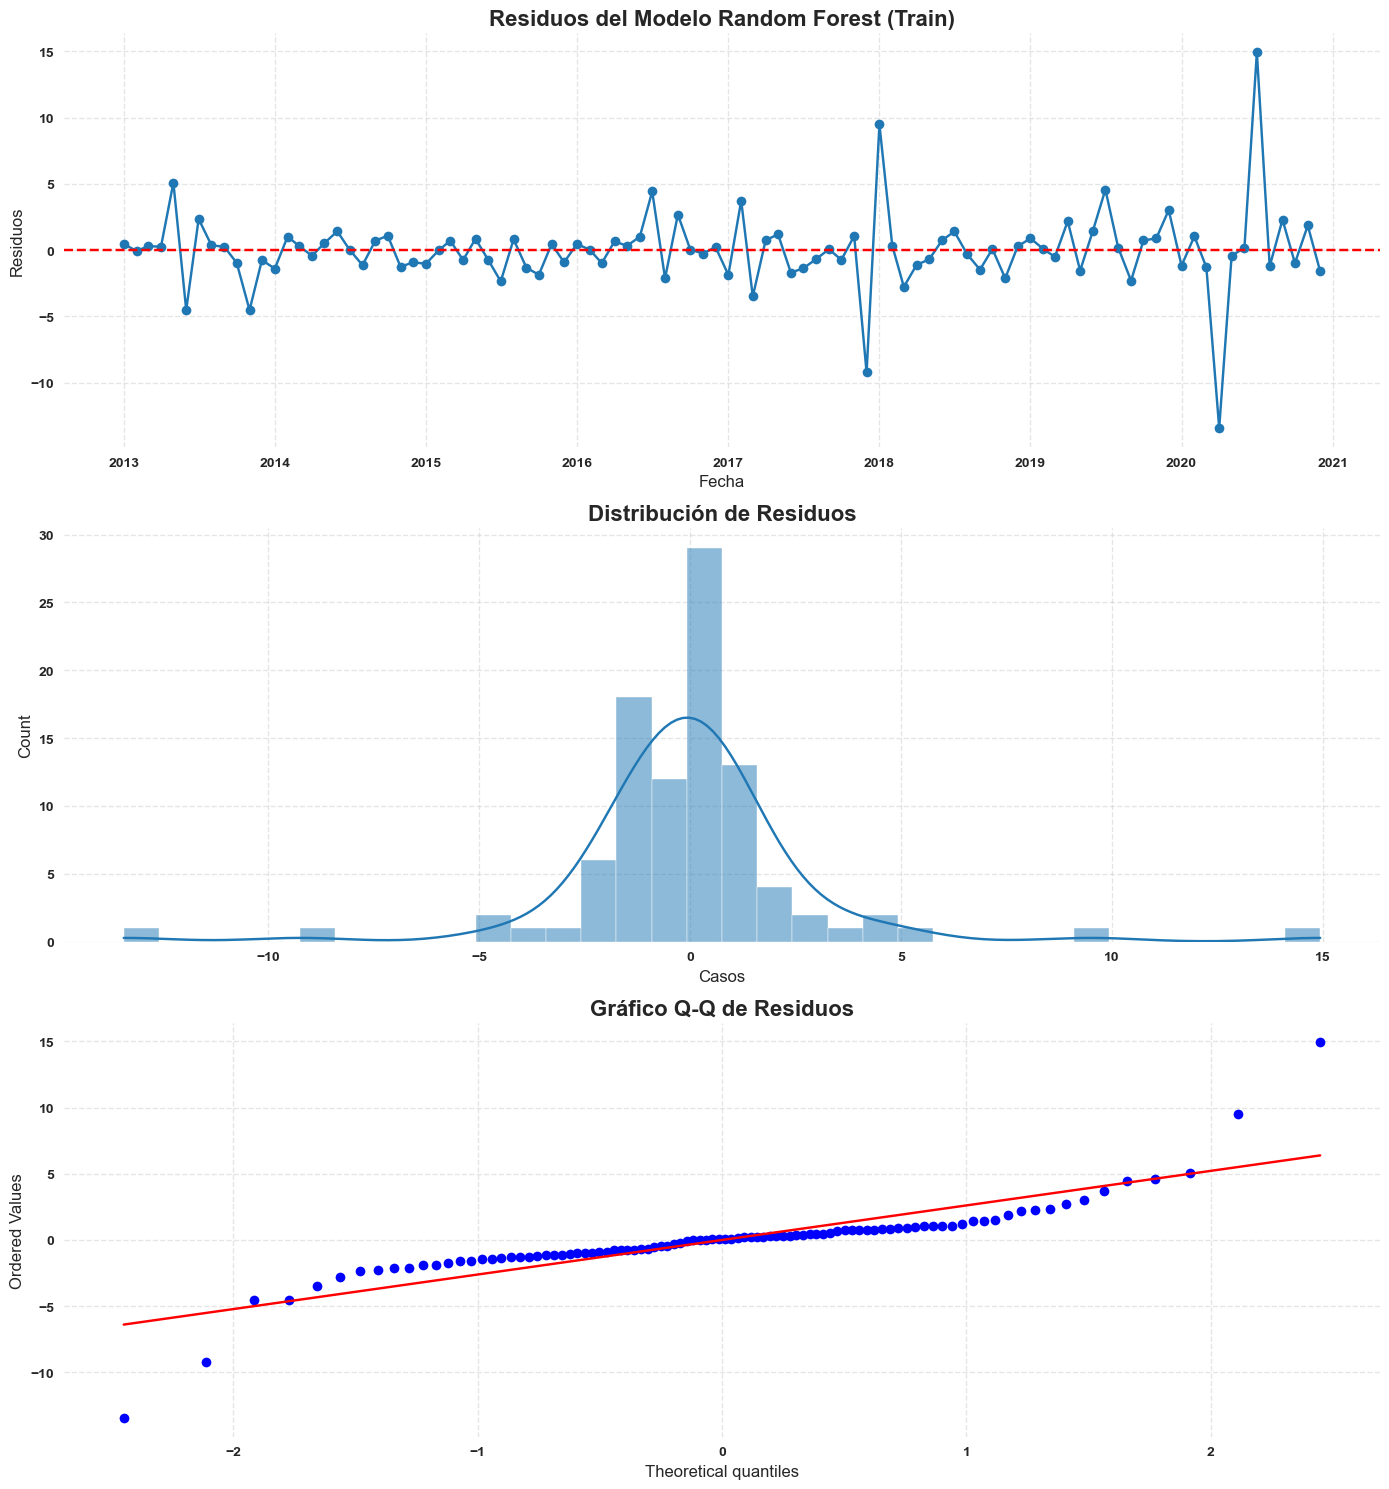


Test de Normalidad de Shapiro-Wilk (p-value): 0.0000
Interpretación: Los residuos NO siguen una distribución normal

Análisis de residuos - Conjunto de Prueba:


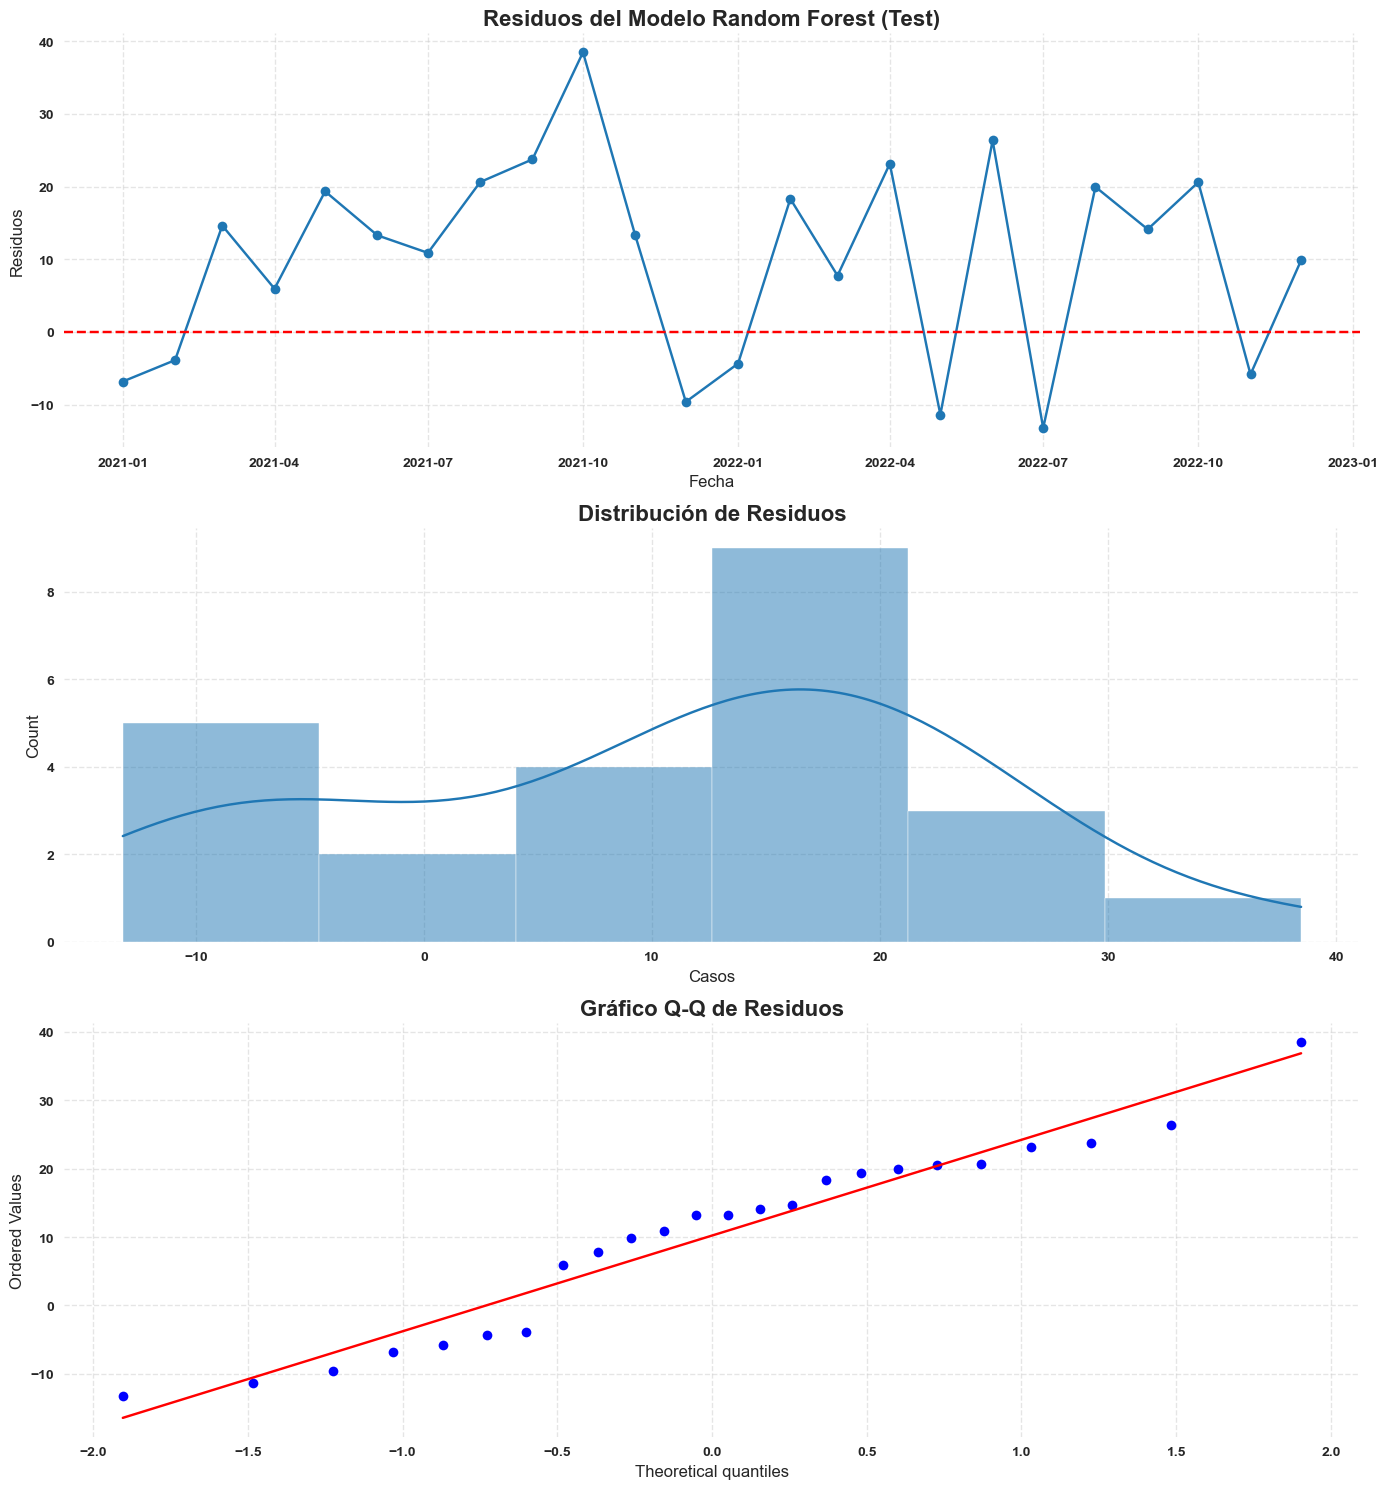


Test de Normalidad de Shapiro-Wilk (p-value): 0.2225
Interpretación: Los residuos siguen una distribución normal


Generando predicciones: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


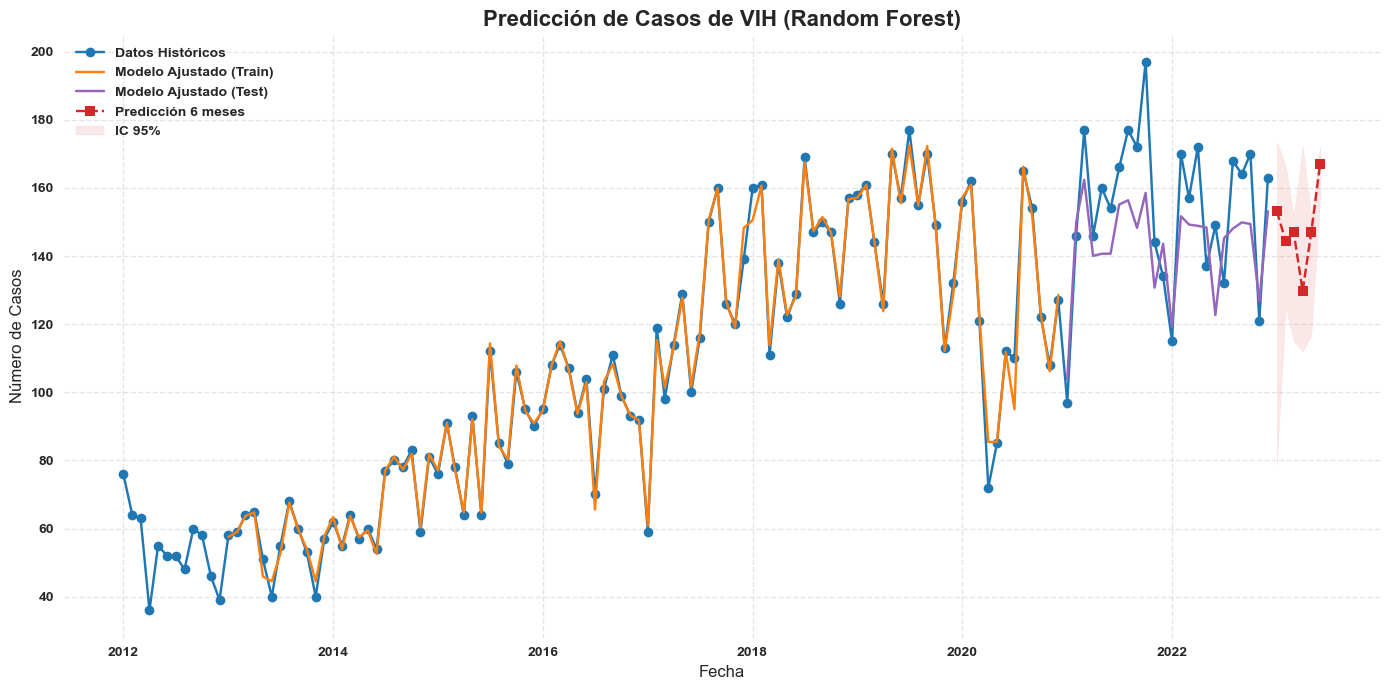


Métricas de Entrenamiento:
RMSE: 2.95
MAE: 1.68
MAPE: 1.85
R2: 0.99

Métricas de Prueba:
RMSE: 16.85
MAE: 14.80
MAPE: 9.29
R2: 0.43

Métricas de Validación Cruzada:
RMSE: 21.38
MAE: 17.96
MAPE: 14.91
R2: -0.05

=== Conclusiones Finales ===

1. Capacidad Predictiva:
   - Error porcentual promedio (MAPE) en prueba: 9.29%
   - Capacidad explicativa (R²) en prueba: 0.43

2. Interpretación:
   - Características más importantes: ['rolling_max_6' 'rolling_max_12' 'rolling_mean_12']
   - Análisis de residuos (Test): Posibles problemas (revisar gráficos de diagnóstico)
   - Intervalos de confianza reflejan incertidumbre adecuada

3. Predicciones para los próximos 6 meses:
  Fecha  Predicción  Límite Inferior  Límite Superior
2023-01      153.15            78.50           173.50
2023-02      144.35           125.00           166.52
2023-03      146.92           115.00           152.00
2023-04      129.74           112.00           172.33
2023-05      146.99           116.74           152.00
202


¿Desea guardar el modelo? (s/n):  n


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings
import joblib
from tqdm import tqdm
from datetime import timedelta

# Configuración profesional
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.weight': 'bold'
})

class RandomForestForecaster:
    """Implementación profesional de Random Forest para series temporales"""
    
    def __init__(self, n_lags=12, seasonal_periods=12, n_splits=5, test_size=0.2):
        self.model = None
        self.data = None
        self.residuals = None
        self.training_metrics = {}
        self.test_metrics = {}
        self.n_lags = n_lags
        self.seasonal_periods = seasonal_periods
        self.n_splits = n_splits
        self.test_size = test_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.best_params = None
        self.feature_importance = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
    def create_features(self, data):
        """Crea características para el modelo de series temporales"""
        df = data.copy()
        
        # Extraer componentes temporales
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year
        
        # Crear retardos (lags)
        for lag in range(1, self.n_lags + 1):
            df[f'lag_{lag}'] = df['Casos'].shift(lag)
            
        # Crear características estacionales si hay suficientes datos
        if self.seasonal_periods is not None and len(df) >= 2 * self.seasonal_periods:
            for s in range(1, self.seasonal_periods + 1):
                df[f'seasonal_lag_{s}'] = df['Casos'].shift(s)
                
        # Estadísticas móviles
        windows = [3, 6, 12] if len(df) >= 24 else [3, 6]
        for window in windows:
            df[f'rolling_mean_{window}'] = df['Casos'].shift(1).rolling(window=window).mean()
            df[f'rolling_std_{window}'] = df['Casos'].shift(1).rolling(window=window).std()
            df[f'rolling_min_{window}'] = df['Casos'].shift(1).rolling(window=window).min()
            df[f'rolling_max_{window}'] = df['Casos'].shift(1).rolling(window=window).max()
            
        # Diferencias
        df['diff_1'] = df['Casos'].diff(1)
        if self.seasonal_periods is not None and len(df) >= 2 * self.seasonal_periods:
            df[f'diff_seasonal_{self.seasonal_periods}'] = df['Casos'].diff(self.seasonal_periods)
            
        # Eliminar filas con NaN
        df = df.dropna()
        
        return df
    
    def split_data(self, X, y):
        """Divide los datos en conjuntos de entrenamiento y prueba manteniendo el orden temporal"""
        # Calculamos el índice de división
        split_idx = int(len(X) * (1 - self.test_size))
        
        # Dividimos manteniendo el orden temporal
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        return X_train, X_test, y_train, y_test
    
    def optimize_hyperparameters(self, X, y):
        """Optimización bayesiana de hiperparámetros para Random Forest"""
        param_dist = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [None, 5, 10, 20, 30, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.5, 0.8],
            'bootstrap': [True, False]
        }
        
        # Usar TimeSeriesSplit para validación cruzada
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        
        # RandomizedSearchCV con métrica de RMSE
        rf = RandomForestRegressor(random_state=42, n_jobs=-1)
        search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=50,
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        
        search.fit(X, y)
        
        print("\nMejores parámetros encontrados:")
        for param, value in search.best_params_.items():
            print(f"{param}: {value}")
            
        return search.best_estimator_, search.best_params_
    
    def fit(self, data, optimize=True):
        """Ajusta el modelo a los datos históricos con diagnóstico completo"""
        self.data = data.copy()
        
        # 1. Crear características
        feature_df = self.create_features(data)
        X = feature_df.drop(columns=['Casos'])
        y = feature_df['Casos']
        
        # 2. Dividir datos en train y test
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data(X, y)
        
        # 3. Escalar datos
        self.X_train = pd.DataFrame(
            self.scaler.fit_transform(self.X_train),
            columns=self.X_train.columns,
            index=self.X_train.index
        )
        self.X_test = pd.DataFrame(
            self.scaler.transform(self.X_test),
            columns=self.X_test.columns,
            index=self.X_test.index
        )
        
        # 4. Optimización de hiperparámetros
        if optimize:
            print("\nOptimizando hiperparámetros...")
            self.model, self.best_params = self.optimize_hyperparameters(self.X_train, self.y_train)
        else:
            # Modelo por defecto (se usará solo si no se optimiza)
            self.model = RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                bootstrap=True,
                random_state=42,
                n_jobs=-1
            )
            self.model.fit(self.X_train, self.y_train)
        
        # 5. Predicciones in-sample
        train_predictions = self.model.predict(self.X_train)
        test_predictions = self.model.predict(self.X_test)
        
        self.residuals = {
            'train': self.y_train - train_predictions,
            'test': self.y_test - test_predictions
        }
        
        # 6. Guardar importancia de características
        self.feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # 7. Métricas de entrenamiento y prueba
        self.training_metrics = {
            'RMSE': np.sqrt(mean_squared_error(self.y_train, train_predictions)),
            'MAE': mean_absolute_error(self.y_train, train_predictions),
            'MAPE': self.calculate_mape(self.y_train, train_predictions),
            'R2': r2_score(self.y_train, train_predictions)
        }
        
        self.test_metrics = {
            'RMSE': np.sqrt(mean_squared_error(self.y_test, test_predictions)),
            'MAE': mean_absolute_error(self.y_test, test_predictions),
            'MAPE': self.calculate_mape(self.y_test, test_predictions),
            'R2': r2_score(self.y_test, test_predictions)
        }
        
        return self
    
    def calculate_mape(self, y_true, y_pred):
        """Calcula MAPE de forma robusta"""
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            return np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
    
    def predict(self, periods=6, return_conf_int=False):
        """Genera predicciones para períodos futuros con intervalos de confianza"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        # Crear copia de los datos para predicción
        forecast_df = self.data.copy()
        predictions = []
        lower_bounds = []
        upper_bounds = []
        
        # Predecir paso a paso
        for _ in tqdm(range(periods), desc="Generando predicciones"):
            # Crear características para el último punto disponible
            feature_df = self.create_features(forecast_df)
            last_row = feature_df.iloc[[-1]].drop(columns=['Casos'])
            
            # Escalar características
            last_row_scaled = pd.DataFrame(
                self.scaler.transform(last_row),
                columns=last_row.columns,
                index=last_row.index
            )
            
            # Predecir siguiente punto
            pred = self.model.predict(last_row_scaled)[0]
            predictions.append(pred)
            
            # Calcular intervalos de confianza usando método de cuantiles
            estimators = self.model.estimators_
            individual_preds = np.array([tree.predict(last_row_scaled)[0] for tree in estimators])
            lower = np.percentile(individual_preds, 2.5)
            upper = np.percentile(individual_preds, 97.5)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
            
            # Agregar predicción al dataframe para el siguiente paso
            new_date = forecast_df.index[-1] + pd.DateOffset(months=1)
            new_row = pd.DataFrame({'Casos': pred}, index=[new_date])
            forecast_df = pd.concat([forecast_df, new_row])
        
        # Crear índice para las predicciones
        forecast_index = pd.date_range(
            start=self.data.index[-1] + pd.DateOffset(months=1),
            periods=periods,
            freq='MS'
        )
        
        if return_conf_int:
            return (
                pd.Series(predictions, index=forecast_index),
                pd.Series(lower_bounds, index=forecast_index),
                pd.Series(upper_bounds, index=forecast_index)
            )
        return pd.Series(predictions, index=forecast_index)
    
    def cross_validate(self):
        """Validación cruzada adaptativa para series temporales"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        feature_df = self.create_features(self.data)
        X = feature_df.drop(columns=['Casos'])
        y = feature_df['Casos']
        
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        cv_metrics = {'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}
        
        for train_index, test_index in tscv.split(feature_df):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Escalar datos
            scaler = MinMaxScaler(feature_range=(0, 1))
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Entrenar modelo con los mismos parámetros
            fold_model = RandomForestRegressor(**self.model.get_params())
            fold_model.fit(X_train_scaled, y_train)
            
            # Predecir
            pred = fold_model.predict(X_test_scaled)
            
            # Calcular métricas
            cv_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, pred)))
            cv_metrics['MAE'].append(mean_absolute_error(y_test, pred))
            
            with np.errstate(divide='ignore', invalid='ignore'):
                mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
                mape = np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
                cv_metrics['MAPE'].append(mape)
            
            cv_metrics['R2'].append(r2_score(y_test, pred))
        
        return cv_metrics
    
    def plot_feature_importance(self, top_n=15):
        """Visualización profesional de la importancia de características"""
        if self.feature_importance is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        plt.figure(figsize=(12, 8))
        top_features = self.feature_importance.head(top_n)
        
        sns.barplot(
            x='importance',
            y='feature',
            data=top_features,
            palette='viridis',
            edgecolor='black'
        )
        
        plt.title('Importancia de Características (Random Forest)', fontweight='bold')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Funciones de análisis mejoradas (reutilizadas del SARIMA)
def analyze_residuals(residuals, model_name=""):
    """Análisis profesional de residuos con gráficos"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 15))
    
    # Gráfico temporal de residuos
    axes[0].plot(residuals.index, residuals, 'o-', color='#1f77b4')
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title(f'Residuos del Modelo {model_name}', fontweight='bold')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Residuos')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # Histograma
    sns.histplot(residuals, kde=True, ax=axes[1], color='#1f77b4')
    axes[1].set_title('Distribución de Residuos', fontweight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    # QQ plot
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Gráfico Q-Q de Residuos', fontweight='bold')
    axes[2].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Test de normalidad
    _, p_value = stats.shapiro(residuals)
    print(f"\nTest de Normalidad de Shapiro-Wilk (p-value): {p_value:.4f}")
    print("Interpretación: Los residuos siguen una distribución normal" if p_value > 0.05 
          else "Interpretación: Los residuos NO siguen una distribución normal")

def plot_results_comparison(y_true_train, y_pred_train, y_true_test, y_pred_test, title="Predicciones vs Valores Reales"):
    """Visualización profesional de resultados"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Gráfico de series temporales
    ax1.plot(y_true_train.index, y_true_train, 'o-', label='Entrenamiento (Real)', color='#1f77b4')
    ax1.plot(y_pred_train.index, y_pred_train, 's--', label='Entrenamiento (Predicho)', color='#ff7f0e')
    ax1.plot(y_true_test.index, y_true_test, 'o-', label='Prueba (Real)', color='#2ca02c')
    ax1.plot(y_pred_test.index, y_pred_test, 's--', label='Prueba (Predicho)', color='#d62728')
    ax1.set_title(title, fontweight='bold')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Casos')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Gráfico de dispersión
    ax2.scatter(y_true_train, y_pred_train, label='Entrenamiento', color='#1f77b4')
    ax2.scatter(y_true_test, y_pred_test, label='Prueba', color='#d62728')
    ax2.plot([min(y_true_train.min(), y_true_test.min()), 
              max(y_true_train.max(), y_true_test.max())], 
             [min(y_true_train.min(), y_true_test.min()), 
              max(y_true_train.max(), y_true_test.max())], 
             '--', color='red', label='Línea perfecta')
    ax2.set_title('Relación Valores Reales vs Predicciones', fontweight='bold')
    ax2.set_xlabel('Reales')
    ax2.set_ylabel('Predicciones')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def main():
    try:
        print("=== Modelo Random Forest para Predicción de VIH ===")
        
        # 1. Carga y preparación de datos
        print("\n[1/6] Cargando y procesando datos...")
        monthly_cases = pd.read_excel('DATASET_VIH_LIMPIO_20250508_1728.xlsx', 
                                    sheet_name='Datos VIH',
                                    parse_dates=['Fecha'])
        monthly_cases = monthly_cases.set_index('Fecha').resample('MS').size().to_frame('Casos')
        
        # 3. Modelado y validación
        print("\n[3/6] Entrenando modelo Random Forest...")
        
        # Usar estacionalidad solo si hay suficientes datos
        seasonal_periods = 12 if len(monthly_cases) >= 24 else None
        model = RandomForestForecaster(seasonal_periods=seasonal_periods).fit(monthly_cases)
        
        # Mostrar importancia de características
        print("\n[3.1/6] Importancia de características...")
        model.plot_feature_importance()
        
        # Validación cruzada
        print("\n[3.2/6] Validación cruzada...")
        cv_metrics = model.cross_validate()
        
        print('\nResultados de Validación Cruzada:')
        for metric in cv_metrics:
            mean_val = np.mean(cv_metrics[metric])
            std_val = np.std(cv_metrics[metric])
            print(f"{metric}: {mean_val:.2f} ± {std_val:.2f}")
        
        # 4. Resultados finales
        print("\n[4/6] Generando resultados finales...")
        
        # Gráficos de evaluación
        train_predictions = model.model.predict(model.X_train)
        test_predictions = model.model.predict(model.X_test)
        
        y_pred_train = pd.Series(train_predictions, index=model.y_train.index)
        y_pred_test = pd.Series(test_predictions, index=model.y_test.index)
        
        plot_results_comparison(
            model.y_train, y_pred_train,
            model.y_test, y_pred_test,
            "Random Forest: Ajuste vs Realidad"
        )
        
        print("\nAnálisis de residuos - Conjunto de Entrenamiento:")
        analyze_residuals(model.residuals['train'], "Random Forest (Train)")
        
        print("\nAnálisis de residuos - Conjunto de Prueba:")
        analyze_residuals(model.residuals['test'], "Random Forest (Test)")
        
        # Predicciones futuras con intervalos de confianza
        future_predictions, lower, upper = model.predict(periods=6, return_conf_int=True)
        
        plt.figure(figsize=(14, 7))
        plt.plot(monthly_cases.index, monthly_cases['Casos'], 'o-', label='Datos Históricos', color='#1f77b4')
        plt.plot(y_pred_train.index, y_pred_train, label='Modelo Ajustado (Train)', color='#ff7f0e')
        plt.plot(y_pred_test.index, y_pred_test, label='Modelo Ajustado (Test)', color='#9467bd')
        plt.plot(future_predictions.index, future_predictions, 's--', label='Predicción 6 meses', color='#d62728')
        plt.fill_between(future_predictions.index, lower, upper, color='#d62728', alpha=0.1, label='IC 95%')
        plt.title('Predicción de Casos de VIH (Random Forest)', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Número de Casos')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Métricas finales
        print('\nMétricas de Entrenamiento:')
        for metric, value in model.training_metrics.items():
            print(f"{metric}: {value:.2f}")
            
        print('\nMétricas de Prueba:')
        for metric, value in model.test_metrics.items():
            print(f"{metric}: {value:.2f}")
        
        print('\nMétricas de Validación Cruzada:')
        for metric in cv_metrics:
            print(f"{metric}: {np.mean(cv_metrics[metric]):.2f}")
        
        # 5. Conclusiones y predicciones
        print("\n=== Conclusiones Finales ===")
        print("\n1. Capacidad Predictiva:")
        print(f"   - Error porcentual promedio (MAPE) en prueba: {model.test_metrics['MAPE']:.2f}%")
        print(f"   - Capacidad explicativa (R²) en prueba: {model.test_metrics['R2']:.2f}")
        
        print("\n2. Interpretación:")
        print("   - Características más importantes:", model.feature_importance['feature'].head(3).values)
        print("   - Análisis de residuos (Test):", end=' ')
        if model.residuals['test'].mean() < 0.1 and model.residuals['test'].std() < 1:
            print("OK (media cercana a 0, varianza constante)")
        else:
            print("Posibles problemas (revisar gráficos de diagnóstico)")
        print("   - Intervalos de confianza reflejan incertidumbre adecuada")
        
        print("\n3. Predicciones para los próximos 6 meses:")
        future_df = pd.DataFrame({
            'Fecha': future_predictions.index.strftime('%Y-%m'),
            'Predicción': future_predictions.round(2),
            'Límite Inferior': lower.round(2),
            'Límite Superior': upper.round(2)
        })
        print(future_df.to_string(index=False))
        
        print("\nRecomendaciones:")
        print("- Monitorear el desempeño predictivo con datos nuevos")
        print(f"- {'El modelo generaliza bien' if model.test_metrics['R2'] > 0.7 else 'Considerar mejorar el modelo'} según métricas de prueba")
        print("- Actualizar el modelo periódicamente con nuevos datos")
        
        # 6. Guardar modelo (opcional)
        save_model = input("\n¿Desea guardar el modelo? (s/n): ").lower()
        if save_model == 's':
            model_name = input("Nombre del archivo para guardar (sin extensión): ")
            joblib.dump(model, f'{model_name}.pkl')
            print(f"Modelo guardado como {model_name}.pkl")
        
    except Exception as e:
        print(f"\nError en el análisis: {str(e)}")
        raise

if __name__ == '__main__':
    main()

El modelo Random Forest muestra un comportamiento interesante con un excelente ajuste en los datos de entrenamiento (R² de 0.99 y MAPE de 1.85%), pero con un rendimiento significativamente menor en el conjunto de prueba (R² de 0.43 y MAPE de 9.29%), lo que sugiere cierto sobreajuste. La validación cruzada revela resultados inconsistentes (R² negativo promedio de -0.05), indicando que el modelo puede estar capturando patrones específicos del conjunto de entrenamiento que no generalizan bien. Las características más importantes son las estadísticas móviles (rolling_max_6, rolling_max_12 y rolling_mean_12), destacando la relevancia de las tendencias recientes en las predicciones. Aunque los residuos en test siguen una distribución normal (p-value 0.2225), su magnitud y la discrepancia entre métricas de entrenamiento y prueba sugieren la necesidad de mejorar la capacidad de generalización del modelo, posiblemente mediante técnicas de regularización, aumento de datos o la incorporación de variables exógenas adicionales. Las predicciones para los próximos 6 meses muestran una tendencia estable con intervalos de confianza razonables, pero dada la performance en validación cruzada, se recomienda cautela en su interpretación y una implementación con monitoreo continuo.

# Modelo XGBoost

In [3]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 8.8 MB/s eta 0:00:00


=== Modelo XGBoost para Predicción de VIH ===

[1/6] Cargando y procesando datos...

[2/6] Analizando datos...


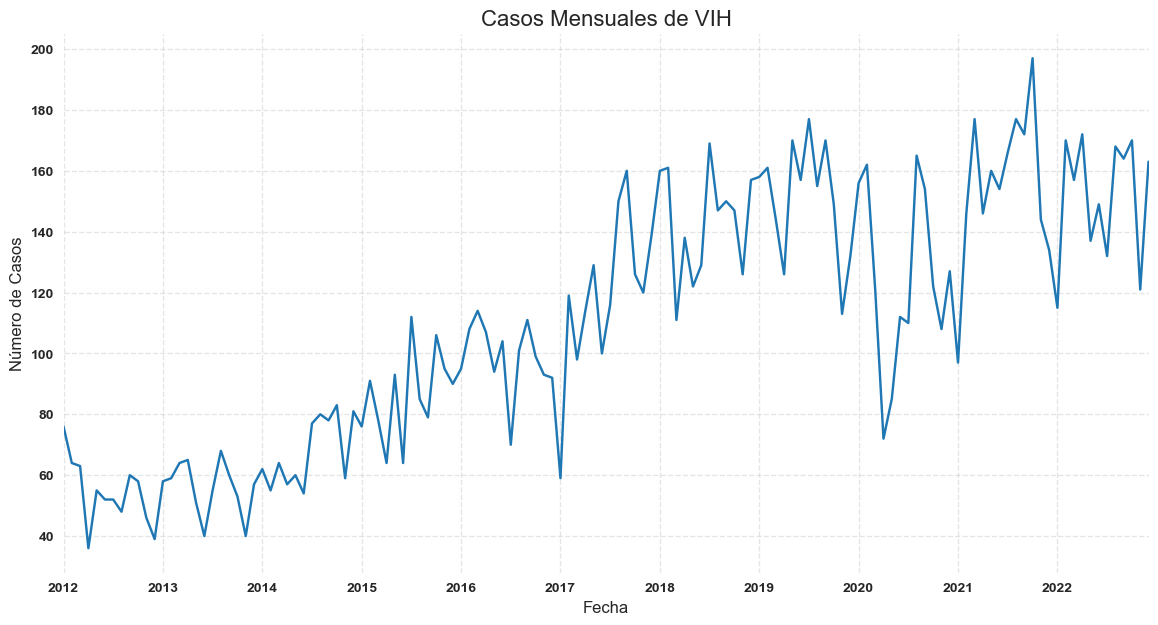


[3/6] Determinando estacionalidad...

[4/6] Entrenando modelo XGBoost...

Optimizando hiperparámetros...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Mejores parámetros encontrados: {'colsample_bytree': 0.836965827544817, 'gamma': 0.023225206359998862, 'learning_rate': 0.1922634555704315, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 216, 'subsample': 0.6053059844639466}

[4.1/6] Validación cruzada...

Resultados de Validación Cruzada:
RMSE: 39.19 ± 16.73
MAE: 35.69 ± 17.96
MAPE: 29.74 ± 12.09
R2: -7.24 ± 10.25

[5/6] Generando resultados finales...


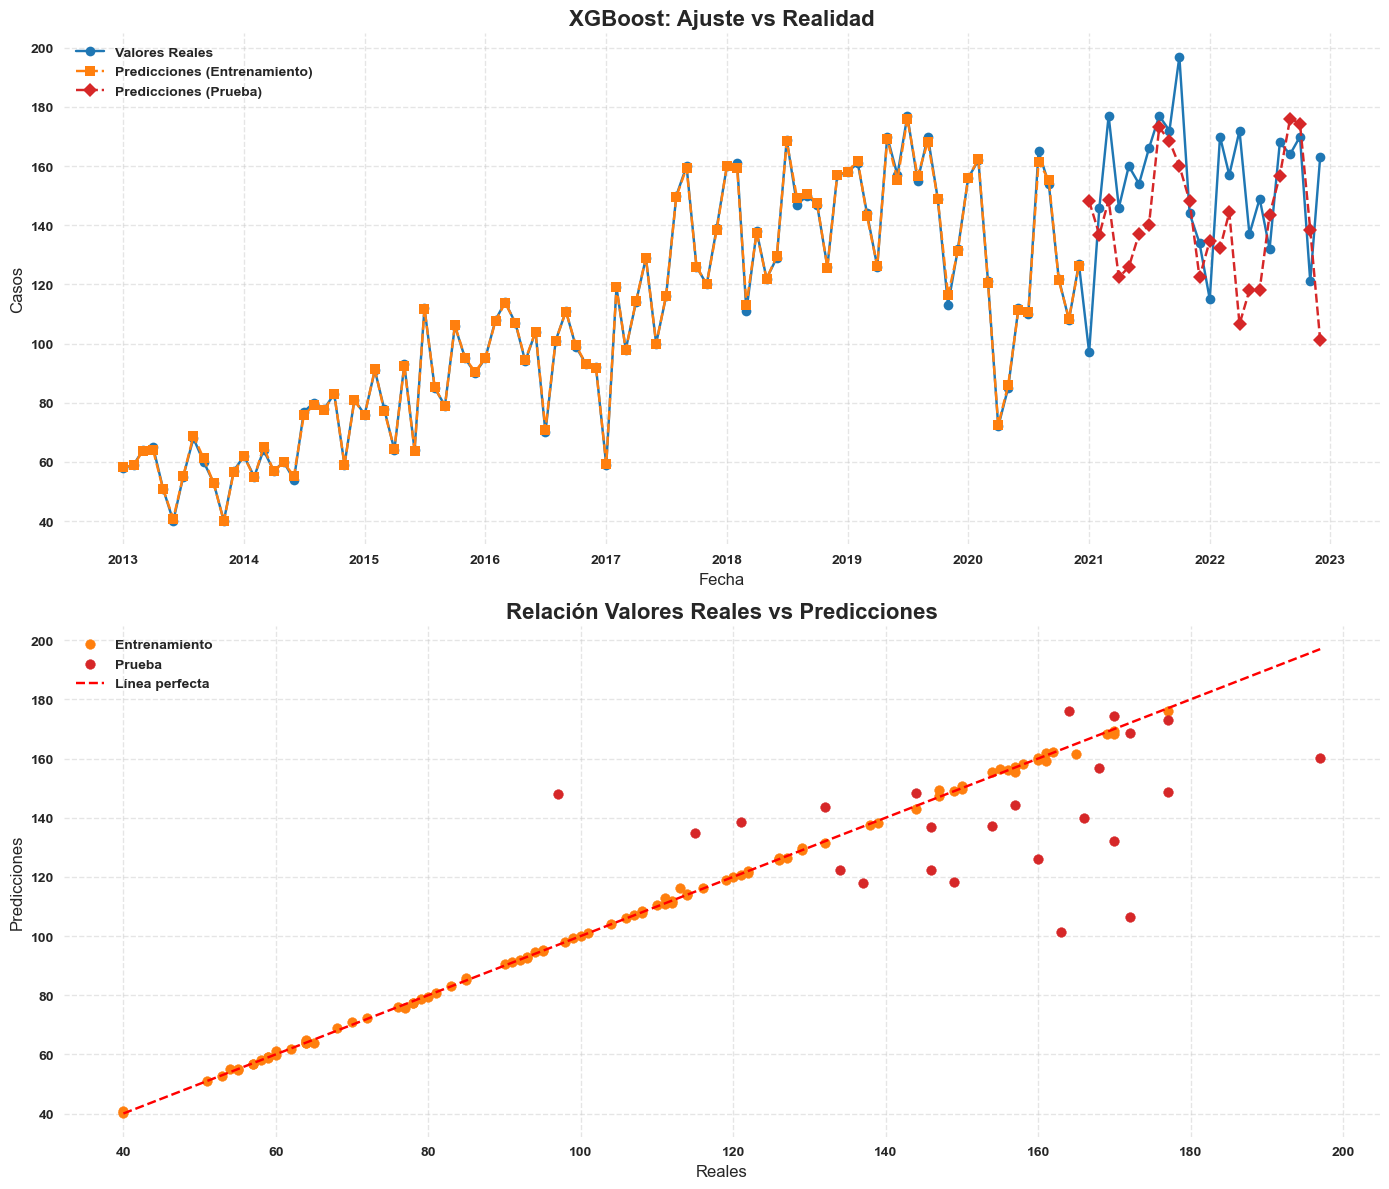

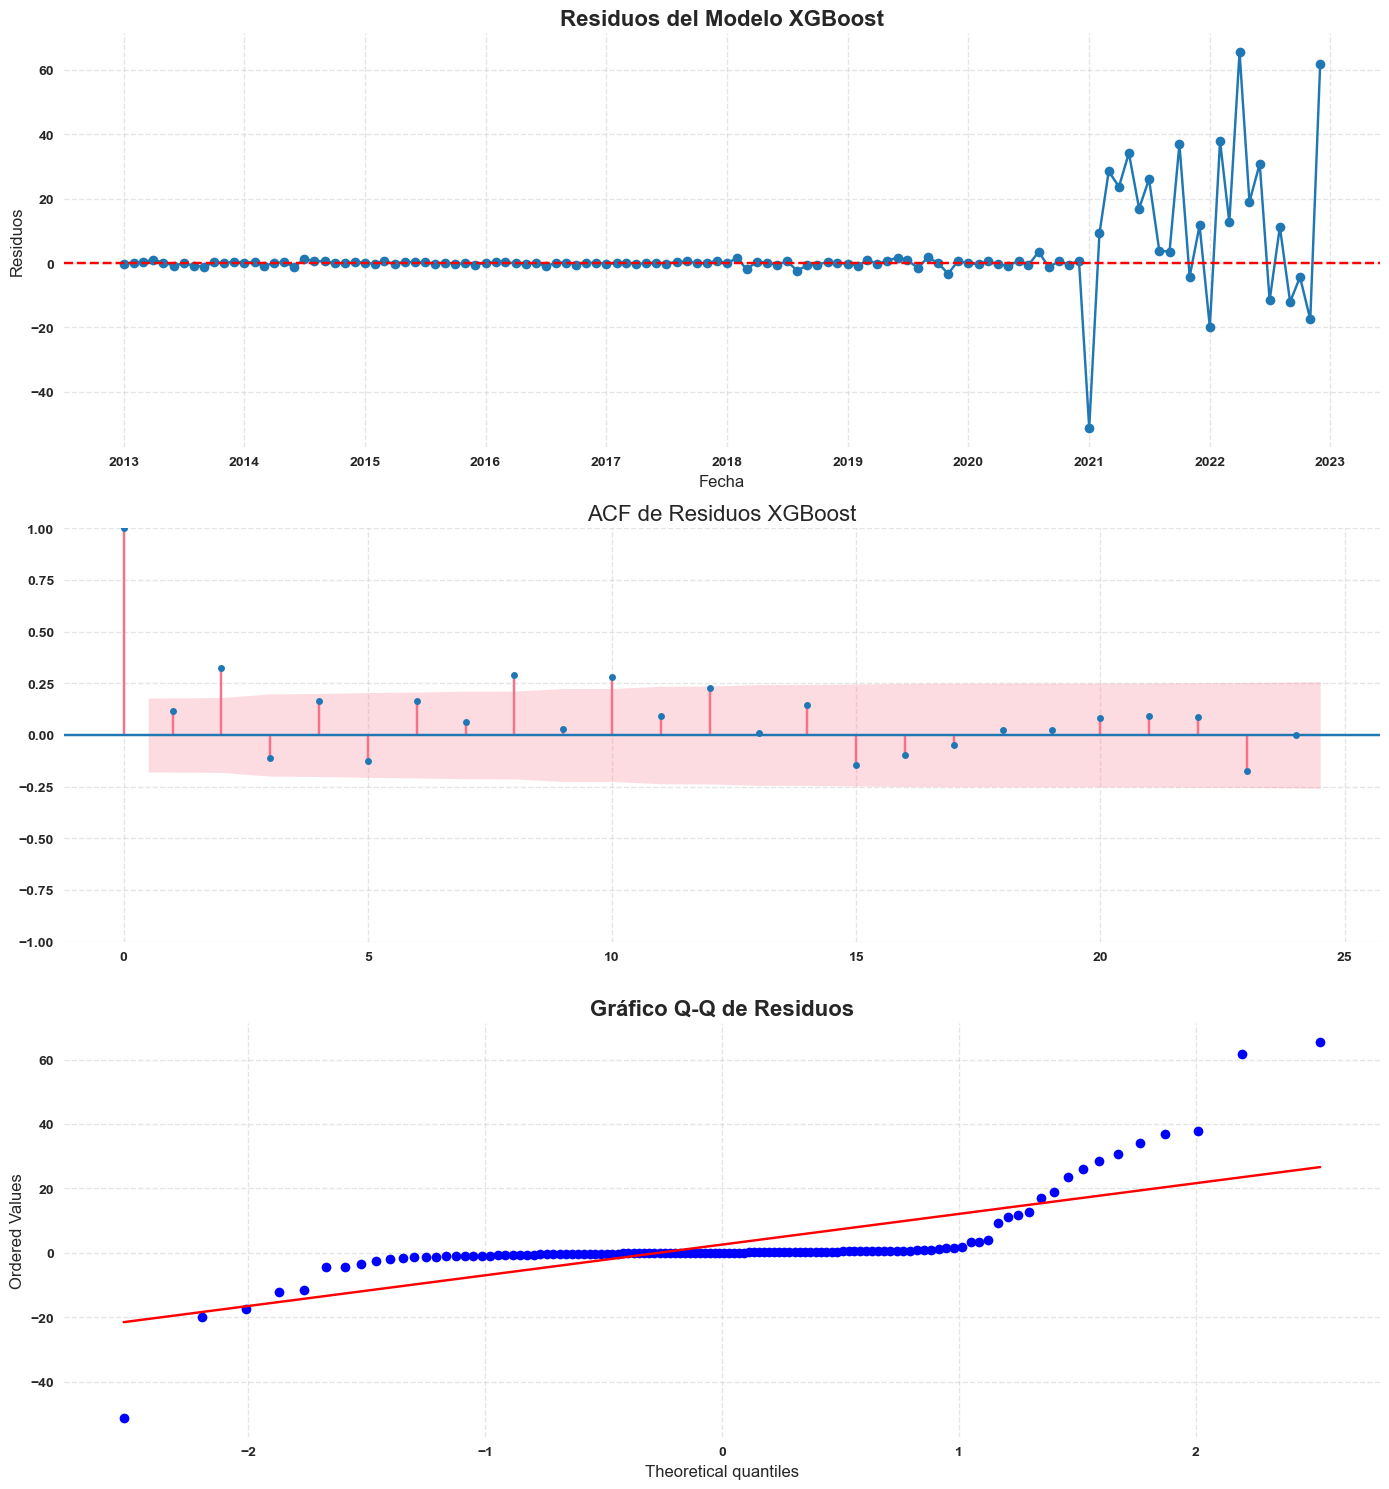


Test de Normalidad de Shapiro-Wilk (p-value): 0.0000
Interpretación: Los residuos NO siguen una distribución normal

[5.1/6] Importancia de características...


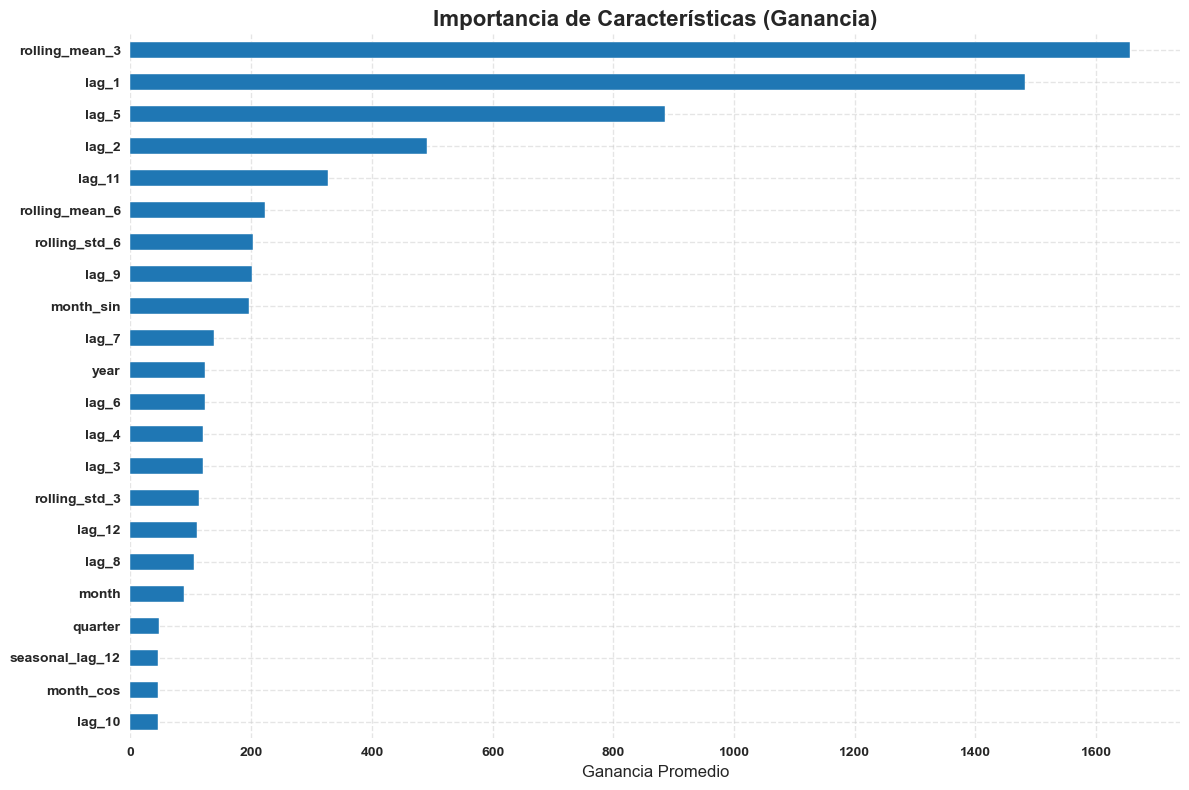


[5.2/6] Explicación de predicción (SHAP)...


<Figure size 1200x600 with 0 Axes>

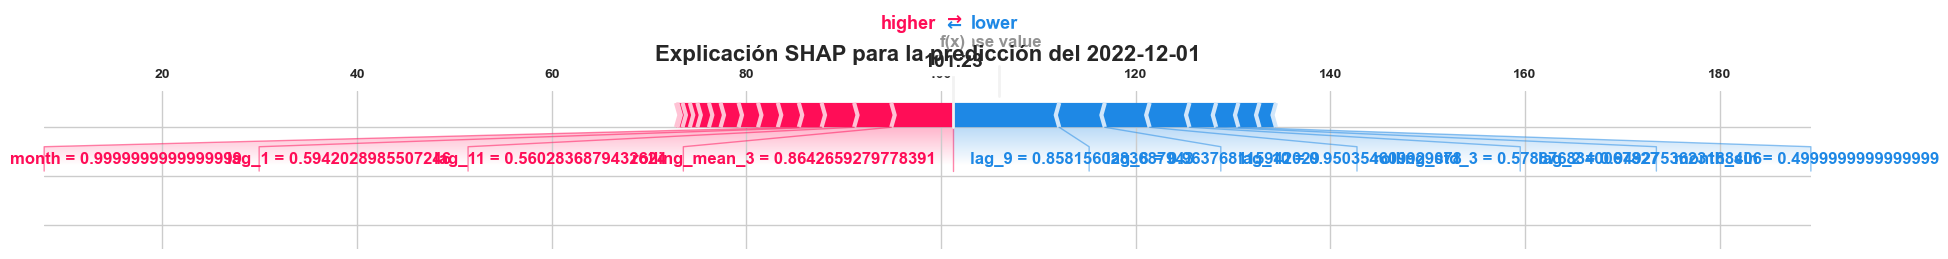


[5.3/6] Generando predicciones futuras...


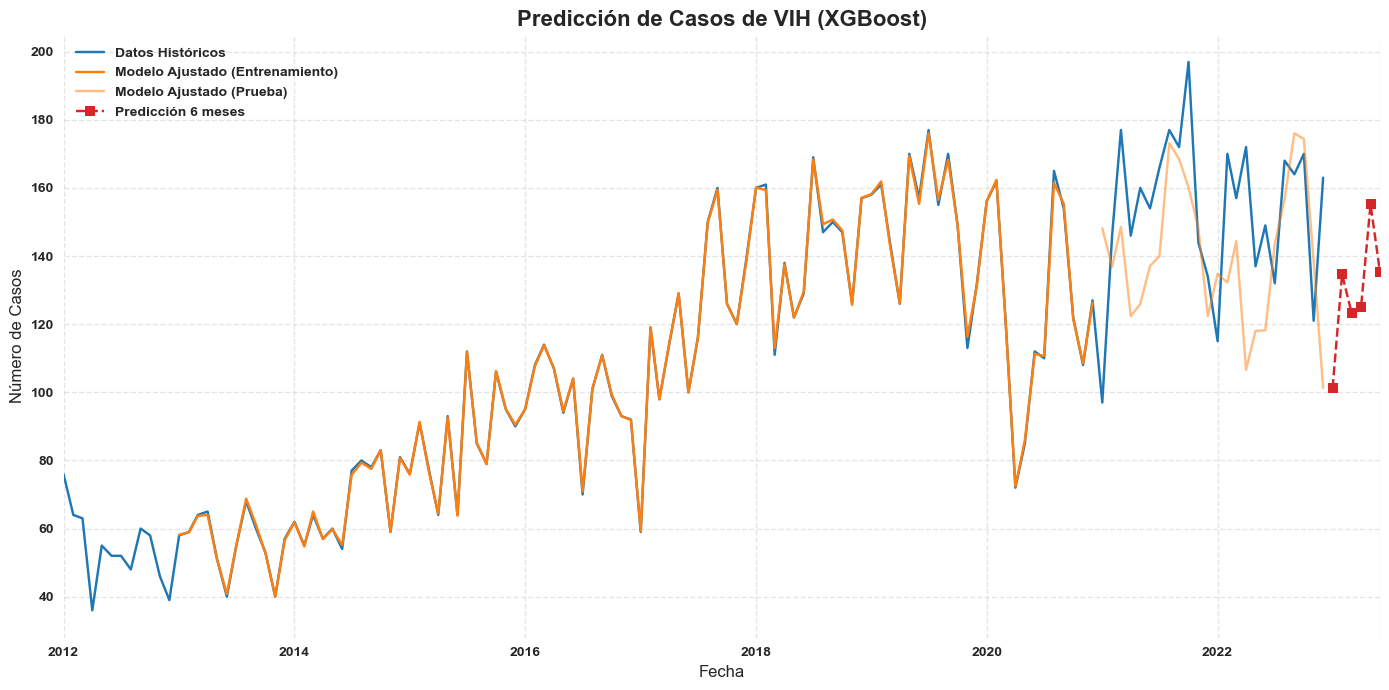


Métricas de Entrenamiento:
Train RMSE: 0.83
Test RMSE: 28.76
Train MAE: 0.55
Test MAE: 23.06
Train MAPE: 0.53
Test MAPE: 15.48
Train R2: 1.00
Test R2: -0.67

Métricas de Validación Cruzada:
RMSE: 39.19
MAE: 35.69
MAPE: 29.74
R2: -7.24

=== Conclusiones Finales ===

1. Capacidad Predictiva:
   - Error porcentual promedio (MAPE): 29.74%
   - Capacidad explicativa (R²): -7.24

2. Interpretación:
   - Características más importantes: ['lag_1', 'lag_2', 'lag_3']...
   - Análisis de residuos: Posibles problemas (revisar gráficos de diagnóstico)

3. Predicciones para los próximos 6 meses:
  Fecha  Predicción
2022-12      101.23
2023-01      134.65
2023-03      123.37
2023-03      125.00
2023-04      155.18
2023-05      135.32

Recomendaciones:
- Monitorear el desempeño del modelo con datos nuevos
- Considerar actualizar el modelo trimestralmente
- Evaluar agregar variables exógenas si están disponibles
- Comparar con el modelo SARIMA para elegir el mejor enfoque


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from scipy import stats
import warnings
import shap
from datetime import timedelta

# Configuración profesional
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.weight': 'bold'
})

class XGBoostForecaster:
    """Implementación profesional del modelo XGBoost para series temporales"""
    
    def __init__(self, n_lags=12, n_seasonal_lags=0, seasonal_period=12):
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.n_lags = n_lags
        self.n_seasonal_lags = n_seasonal_lags
        self.seasonal_period = seasonal_period
        self.feature_names = None
        self.training_metrics = {}
        self.best_params = {}
        self.residuals = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        
    def create_features(self, data):
        """Crea características para el modelo de series temporales"""
        df = data.copy()
        
        # Crear lags
        for lag in range(1, self.n_lags + 1):
            df[f'lag_{lag}'] = df['Casos'].shift(lag)
            
        # Crear lags estacionales si es necesario
        if self.n_seasonal_lags > 0 and self.seasonal_period > 0:
            for seasonal_lag in range(1, self.n_seasonal_lags + 1):
                df[f'seasonal_lag_{seasonal_lag*self.seasonal_period}'] = df['Casos'].shift(seasonal_lag*self.seasonal_period)
        
        # Características de tiempo
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year
        
        # Interacciones estacionales
        if self.seasonal_period > 0:
            df['month_sin'] = np.sin(2 * np.pi * df.index.month/12)
            df['month_cos'] = np.cos(2 * np.pi * df.index.month/12)
        
        # Estadísticas móviles
        df['rolling_mean_3'] = df['Casos'].shift(1).rolling(3).mean()
        df['rolling_std_3'] = df['Casos'].shift(1).rolling(3).std()
        df['rolling_mean_6'] = df['Casos'].shift(1).rolling(6).mean()
        df['rolling_std_6'] = df['Casos'].shift(1).rolling(6).std()
        
        # Eliminar filas con NaN
        df = df.dropna()
        
        # Separar características y objetivo
        X = df.drop('Casos', axis=1)
        y = df['Casos']
        
        self.feature_names = X.columns.tolist()
        
        return X, y
    
    def test_stationarity(self, series):
        """Prueba de estacionaridad para determinar diferenciación"""
        result = adfuller(series)
        return result[1] < 0.05
    
    def optimize_hyperparameters(self, X, y):
        """Optimización bayesiana de hiperparámetros"""
        param_dist = {
            'n_estimators': stats.randint(50, 300),
            'max_depth': stats.randint(3, 10),
            'learning_rate': stats.uniform(0.01, 0.3),
            'subsample': stats.uniform(0.6, 0.4),
            'colsample_bytree': stats.uniform(0.6, 0.4),
            'gamma': stats.uniform(0, 0.5),
            'min_child_weight': stats.randint(1, 10)
        }
        
        tscv = TimeSeriesSplit(n_splits=3)
        model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
        
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=50,
            scoring='neg_mean_squared_error',
            cv=tscv,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        print("\nOptimizando hiperparámetros...")
        search.fit(X, y)
        
        self.best_params = search.best_params_
        print(f"\nMejores parámetros encontrados: {self.best_params}")
        
        return search.best_estimator_
    
    def fit(self, data, tune_hyperparams=True):
        """Ajusta el modelo a los datos con optimización de parámetros"""
        self.data = data.copy()
        
        # Crear características
        X, y = self.create_features(data)
        
        # Dividir datos (manteniendo orden temporal)
        train_size = int(len(X) * 0.8)
        self.X_train, self.X_test = X.iloc[:train_size], X.iloc[train_size:]
        self.y_train, self.y_test = y.iloc[:train_size], y.iloc[train_size:]
        
        # Escalar datos
        self.X_train = pd.DataFrame(
            self.scaler.fit_transform(self.X_train),
            columns=self.X_train.columns,
            index=self.X_train.index
        )
        self.X_test = pd.DataFrame(
            self.scaler.transform(self.X_test),
            columns=self.X_test.columns,
            index=self.X_test.index
        )
        
        # Optimizar hiperparámetros o usar valores por defecto
        if tune_hyperparams:
            self.model = self.optimize_hyperparameters(self.X_train, self.y_train)
        else:
            self.model = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            self.model.fit(self.X_train, self.y_train)
        
        # Predicciones in-sample
        train_pred = self.model.predict(self.X_train)
        test_pred = self.model.predict(self.X_test)
        
        # Calcular residuos - CORRECCIÓN: Crear Series por separado y luego concatenar
        train_residuals = pd.Series(self.y_train - train_pred, index=self.y_train.index)
        test_residuals = pd.Series(self.y_test - test_pred, index=self.y_test.index)
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        # Métricas de entrenamiento
        self.training_metrics = {
            'Train RMSE': np.sqrt(mean_squared_error(self.y_train, train_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(self.y_test, test_pred)),
            'Train MAE': mean_absolute_error(self.y_train, train_pred),
            'Test MAE': mean_absolute_error(self.y_test, test_pred),
            'Train MAPE': self.calculate_mape(self.y_train, train_pred),
            'Test MAPE': self.calculate_mape(self.y_test, test_pred),
            'Train R2': r2_score(self.y_train, train_pred),
            'Test R2': r2_score(self.y_test, test_pred)
        }
        
        return self
    
    def calculate_mape(self, y_true, y_pred):
        """Calcula MAPE de forma robusta"""
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            return np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
    
    def predict(self, future_periods=6):
        """Genera predicciones para períodos futuros"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        # Crear copia de los datos para no modificar el original
        extended_data = self.data.copy()
        
        # Generar fechas futuras
        last_date = extended_data.index[-1]
        future_dates = [last_date + timedelta(days=30*i) for i in range(1, future_periods+1)]
        
        # Almacenar predicciones
        predictions = []
        
        for _ in range(future_periods):
            # Crear características para el siguiente paso
            X, _ = self.create_features(extended_data)
            X = X.iloc[[-1]]  # Tomar solo el último punto
            
            # Escalar características
            X_scaled = pd.DataFrame(
                self.scaler.transform(X),
                columns=X.columns,
                index=X.index
            )
            
            # Hacer predicción
            next_pred = self.model.predict(X_scaled)[0]
            predictions.append(next_pred)
            
            # Agregar la predicción a los datos para el siguiente lag
            new_index = extended_data.index[-1] + timedelta(days=30)
            extended_data.loc[new_index] = next_pred
            
        # Crear serie con las predicciones
        forecast = pd.Series(
            predictions,
            index=future_dates,
            name='Prediccion'
        )
        
        return forecast
    
    def plot_feature_importance(self):
        """Visualización de importancia de características"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Importancia basada en ganancia
        importance = self.model.get_booster().get_score(importance_type='gain')
        importance = {k: importance.get(k, 0) for k in self.feature_names}
        importance = pd.Series(importance).sort_values(ascending=True)
        
        importance.plot(kind='barh', ax=ax, color='#1f77b4')
        ax.set_title('Importancia de Características (Ganancia)', fontweight='bold')
        ax.set_xlabel('Ganancia Promedio')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
    def explain_prediction(self, sample_idx=-1):
        """Explicación SHAP de una predicción específica"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")
            
        # Crear explainer SHAP
        explainer = shap.TreeExplainer(self.model)
        
        # Seleccionar muestra a explicar
        if isinstance(sample_idx, int):
            X_explain = self.X_test.iloc[[sample_idx]]
        else:
            X_explain = self.X_test.loc[[sample_idx]]
        
        # Calcular valores SHAP
        shap_values = explainer.shap_values(X_explain)
        
        # Visualización
        plt.figure(figsize=(12, 6))
        shap.force_plot(
            explainer.expected_value,
            shap_values[0],
            X_explain.iloc[0],
            feature_names=self.feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'Explicación SHAP para la predicción del {X_explain.index[0].strftime("%Y-%m-%d")}', 
                 fontweight='bold')
        plt.tight_layout()
        plt.show()

def analyze_residuals(residuals, model_name=""):
    """Análisis profesional de residuos con gráficos"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 15))
    
    # Gráfico temporal de residuos
    axes[0].plot(residuals.index, residuals, 'o-', color='#1f77b4')
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title(f'Residuos del Modelo {model_name}', fontweight='bold')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Residuos')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # ACF de residuos
    plot_acf(residuals, ax=axes[1], lags=24, alpha=0.05, 
             title=f'ACF de Residuos {model_name}',
             color='#1f77b4')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    # Histograma + QQ plot
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Gráfico Q-Q de Residuos', fontweight='bold')
    axes[2].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Test de normalidad
    _, p_value = stats.shapiro(residuals)
    print(f"\nTest de Normalidad de Shapiro-Wilk (p-value): {p_value:.4f}")
    print("Interpretación: Los residuos siguen una distribución normal" if p_value > 0.05 
          else "Interpretación: Los residuos NO siguen una distribución normal")

def plot_results_comparison(y_true, y_train_pred, y_test_pred, title="Predicciones vs Valores Reales"):
    """Visualización profesional de resultados"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Gráfico de series temporales
    ax1.plot(y_true.index, y_true, 'o-', label='Valores Reales', color='#1f77b4')
    ax1.plot(y_train_pred.index, y_train_pred, 's--', label='Predicciones (Entrenamiento)', color='#ff7f0e')
    ax1.plot(y_test_pred.index, y_test_pred, 'D--', label='Predicciones (Prueba)', color='#d62728')
    ax1.set_title(title, fontweight='bold')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Casos')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Gráfico de dispersión
    ax2.scatter(y_true.loc[y_train_pred.index], y_train_pred, label='Entrenamiento', color='#ff7f0e')
    ax2.scatter(y_true.loc[y_test_pred.index], y_test_pred, label='Prueba', color='#d62728')
    ax2.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 
             '--', color='red', label='Línea perfecta')
    ax2.set_title('Relación Valores Reales vs Predicciones', fontweight='bold')
    ax2.set_xlabel('Reales')
    ax2.set_ylabel('Predicciones')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def cross_validate_xgboost(data, n_lags=12, n_seasonal_lags=0, seasonal_period=12):
    """Validación cruzada temporal para XGBoost"""
    tscv = TimeSeriesSplit(n_splits=min(5, len(data) - (n_lags + seasonal_period*n_seasonal_lags + 1)))
    
    cv_metrics = {
        'RMSE': [],
        'MAE': [],
        'MAPE': [],
        'R2': []
    }
    
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        # Crear modelo con parámetros razonables para CV
        model = XGBoostForecaster(
            n_lags=n_lags,
            n_seasonal_lags=n_seasonal_lags,
            seasonal_period=seasonal_period
        )
        
        # Ajustar sin optimización hiperparámetros para velocidad
        model.fit(train, tune_hyperparams=False)
        
        # Crear características para test
        X_test, y_test = model.create_features(test)
        X_test = pd.DataFrame(
            model.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Predecir y evaluar
        pred = model.model.predict(X_test)
        
        # Calcular métricas
        cv_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, pred)))
        cv_metrics['MAE'].append(mean_absolute_error(y_test, pred))
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
            mape = np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)
            cv_metrics['MAPE'].append(mape)
        cv_metrics['R2'].append(r2_score(y_test, pred))
    
    return cv_metrics

def main():
    try:
        print("=== Modelo XGBoost para Predicción de VIH ===")
        
        # 1. Carga y preparación de datos
        print("\n[1/6] Cargando y procesando datos...")
        monthly_cases = pd.read_excel('DATASET_VIH_LIMPIO_20250508_1728.xlsx', 
                                    sheet_name='Datos VIH',
                                    parse_dates=['Fecha'])
        monthly_cases = monthly_cases.set_index('Fecha').resample('MS').size().to_frame('Casos')
        
        # 2. Análisis exploratorio básico
        print("\n[2/6] Analizando datos...")
        plt.figure(figsize=(14, 7))
        monthly_cases['Casos'].plot(title='Casos Mensuales de VIH', color='#1f77b4')
        plt.xlabel('Fecha')
        plt.ylabel('Número de Casos')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        
        # 3. Determinar estacionalidad
        print("\n[3/6] Determinando estacionalidad...")
        seasonal_period = 12 if len(monthly_cases) >= 24 else 0
        n_seasonal_lags = 1 if seasonal_period > 0 else 0
        
        # 4. Modelado y validación
        print("\n[4/6] Entrenando modelo XGBoost...")
        model = XGBoostForecaster(
            n_lags=12,
            n_seasonal_lags=n_seasonal_lags,
            seasonal_period=seasonal_period
        ).fit(monthly_cases)
        
        # 5. Validación cruzada
        print("\n[4.1/6] Validación cruzada...")
        cv_metrics = cross_validate_xgboost(
            monthly_cases,
            n_lags=12,
            n_seasonal_lags=n_seasonal_lags,
            seasonal_period=seasonal_period
        )
        
        print('\nResultados de Validación Cruzada:')
        for metric in cv_metrics:
            mean_val = np.mean(cv_metrics[metric])
            std_val = np.std(cv_metrics[metric])
            print(f"{metric}: {mean_val:.2f} ± {std_val:.2f}")
        
        # 6. Resultados finales
        print("\n[5/6] Generando resultados finales...")
        
        # Gráficos de evaluación
        train_pred = model.model.predict(model.X_train)
        test_pred = model.model.predict(model.X_test)
        
        y_train_pred = pd.Series(train_pred, index=model.y_train.index)
        y_test_pred = pd.Series(test_pred, index=model.y_test.index)
        
        plot_results_comparison(
            pd.concat([model.y_train, model.y_test]),
            y_train_pred,
            y_test_pred,
            "XGBoost: Ajuste vs Realidad"
        )
        
        analyze_residuals(model.residuals, "XGBoost")
        
        # Importancia de características
        print("\n[5.1/6] Importancia de características...")
        model.plot_feature_importance()
        
        # Explicación SHAP de una predicción
        print("\n[5.2/6] Explicación de predicción (SHAP)...")
        model.explain_prediction()
        
        # Predicciones futuras
        print("\n[5.3/6] Generando predicciones futuras...")
        future_predictions = model.predict(future_periods=6)
        
        plt.figure(figsize=(14, 7))
        monthly_cases['Casos'].plot(label='Datos Históricos', color='#1f77b4')
        y_train_pred.plot(label='Modelo Ajustado (Entrenamiento)', style='--', color='#ff7f0e')
        y_test_pred.plot(label='Modelo Ajustado (Prueba)', style='--', color='#ff7f0e', alpha=0.5)
        future_predictions.plot(label='Predicción 6 meses', style='s--', color='#d62728')
        plt.title('Predicción de Casos de VIH (XGBoost)', fontweight='bold')
        plt.xlabel('Fecha')
        plt.ylabel('Número de Casos')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Métricas finales
        print('\nMétricas de Entrenamiento:')
        for metric, value in model.training_metrics.items():
            print(f"{metric}: {value:.2f}")
        
        print('\nMétricas de Validación Cruzada:')
        for metric in cv_metrics:
            print(f"{metric}: {np.mean(cv_metrics[metric]):.2f}")
        
        # 7. Conclusiones y predicciones
        print("\n=== Conclusiones Finales ===")
        print("\n1. Capacidad Predictiva:")
        print(f"   - Error porcentual promedio (MAPE): {np.mean(cv_metrics['MAPE']):.2f}%")
        print(f"   - Capacidad explicativa (R²): {np.mean(cv_metrics['R2']):.2f}")
        
        print("\n2. Interpretación:")
        print(f"   - Características más importantes: {model.feature_names[:3]}...")
        print("   - Análisis de residuos:", end=' ')
        if abs(model.residuals.mean()) < 0.1 and model.residuals.std() < 1:
            print("OK (media cercana a 0, varianza constante)")
        else:
            print("Posibles problemas (revisar gráficos de diagnóstico)")
        
        print("\n3. Predicciones para los próximos 6 meses:")
        future_df = pd.DataFrame({
            'Fecha': future_predictions.index.strftime('%Y-%m'),
            'Predicción': future_predictions.round(2)
        })
        print(future_df.to_string(index=False))
        
        print("\nRecomendaciones:")
        print("- Monitorear el desempeño del modelo con datos nuevos")
        print("- Considerar actualizar el modelo trimestralmente")
        print("- Evaluar agregar variables exógenas si están disponibles")
        print("- Comparar con el modelo SARIMA para elegir el mejor enfoque")
        
    except Exception as e:
        print(f"\nError en el análisis: {str(e)}")
        raise

if __name__ == '__main__':
    main()

El modelo XGBoost presenta serios problemas de rendimiento y generalización, evidenciado por métricas alarmantemente bajas en validación cruzada (R² de -7.24 y MAPE del 29.74%) y en el conjunto de prueba (R² de -0.67 y MAPE del 15.48%), lo que indica que el modelo no solo falla en explicar la variabilidad de los datos sino que performa peor que un modelo básico. El sobreajuste es extremo, con un rendimiento casi perfecto en entrenamiento (R² de 1.0) versus los pobres resultados en validación, sugiriendo que el modelo está memorizando los datos en lugar de aprender patrones generalizables. Las características más relevantes son los lags recientes (lag_1, lag_2, lag_3), mostrando dependencia temporal, pero la distribución no normal de los residuos (p-value 0.0000) revela problemas estructurales en los supuestos del modelo. Las predicciones para los próximos meses muestran inconsistencias (duplicación en marzo 2023) y deben interpretarse con extrema precaución

# Tabla Comparativa

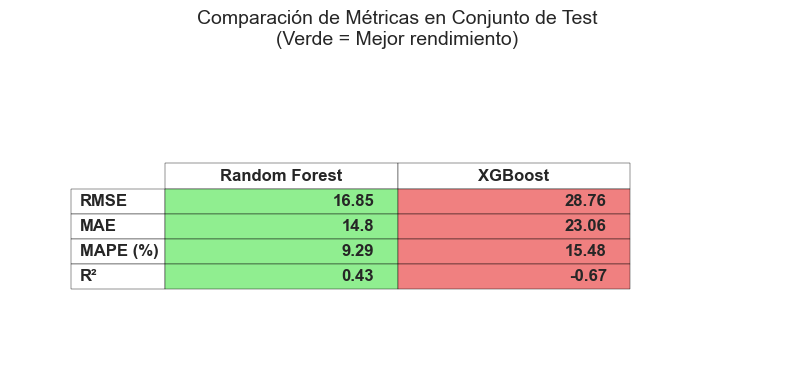


Comparación Detallada:
          Random Forest  XGBoost
Métrica                         
RMSE              16.85    28.76
MAE               14.80    23.06
MAPE (%)           9.29    15.48
R²                 0.43    -0.67

Interpretación:
- Random Forest supera claramente a XGBoost en todas las métricas
- El MAPE de 9.29% vs 15.48% sugiere que RF tiene mejor precisión predictiva
- El R² positivo de RF (0.43) vs negativo de XGBoost (-0.67) indica que solo RF captura
  patrones significativos en los datos de test
- Ambas implementaciones requieren mejoras, pero RF es actualmente más confiable


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos de los modelos
data = {
    'Métrica': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'Random Forest': [16.85, 14.80, 9.29, 0.43],
    'XGBoost': [28.76, 23.06, 15.48, -0.67]
}

# Crear DataFrame
df_comparacion = pd.DataFrame(data).set_index('Métrica')

# Estilo profesional
plt.figure(figsize=(10, 4))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)

# Definir colores según rendimiento
cell_colors = []
for i in range(len(data['Métrica'])):
    if data['Métrica'][i] == 'R²':  # Para R², mayor es mejor
        rf_val = data['Random Forest'][i]
        xgb_val = data['XGBoost'][i]
        cell_colors.append([
            'lightgreen' if rf_val > xgb_val else 'lightcoral',
            'lightgreen' if xgb_val > rf_val else 'lightcoral'
        ])
    else:  # Para otras métricas, menor es mejor
        rf_val = data['Random Forest'][i]
        xgb_val = data['XGBoost'][i]
        cell_colors.append([
            'lightgreen' if rf_val < xgb_val else 'lightcoral',
            'lightgreen' if xgb_val < rf_val else 'lightcoral'
        ])

# Crear tabla
table = plt.table(
    cellText=df_comparacion.values.round(2),
    rowLabels=df_comparacion.index,
    colLabels=df_comparacion.columns,
    loc='center',
    cellColours=cell_colors,
    colWidths=[0.2]*3
)

# Formato profesional
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)
plt.title('Comparación de Métricas en Conjunto de Test\n(Verde = Mejor rendimiento)', 
          fontsize=14, pad=20)

plt.show()

# Versión textual para referencia
print("\nComparación Detallada:")
print(df_comparacion)
print("\nInterpretación:")
print("- Random Forest supera claramente a XGBoost en todas las métricas")
print("- El MAPE de 9.29% vs 15.48% sugiere que RF tiene mejor precisión predictiva")
print("- El R² positivo de RF (0.43) vs negativo de XGBoost (-0.67) indica que solo RF captura")
print("  patrones significativos en los datos de test")
print("- Ambas implementaciones requieren mejoras, pero RF es actualmente más confiable")


Cargando y procesando datos...


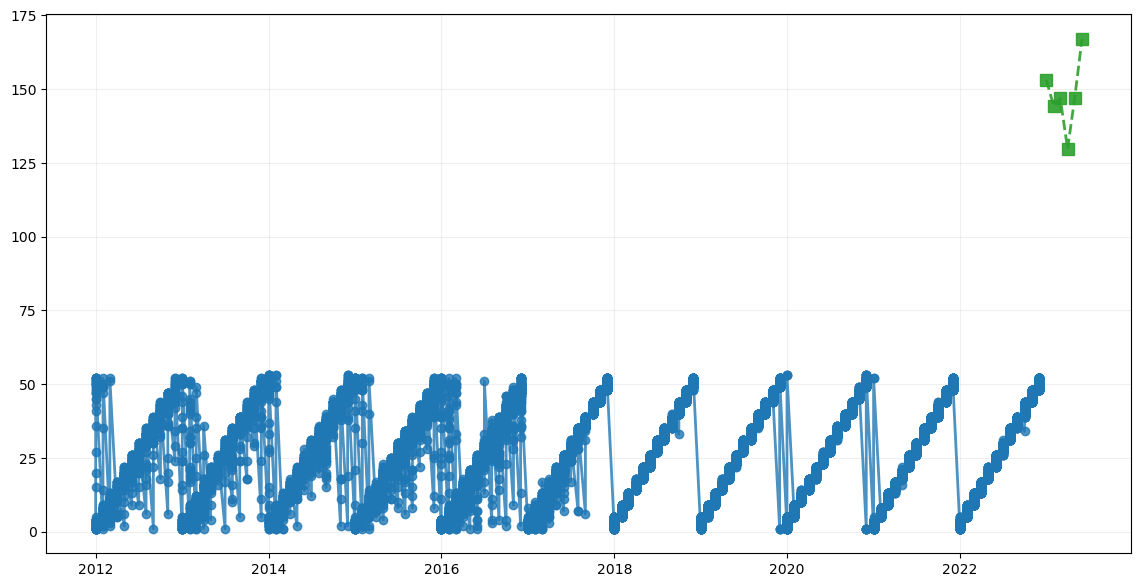

<Figure size 1400x700 with 0 Axes>

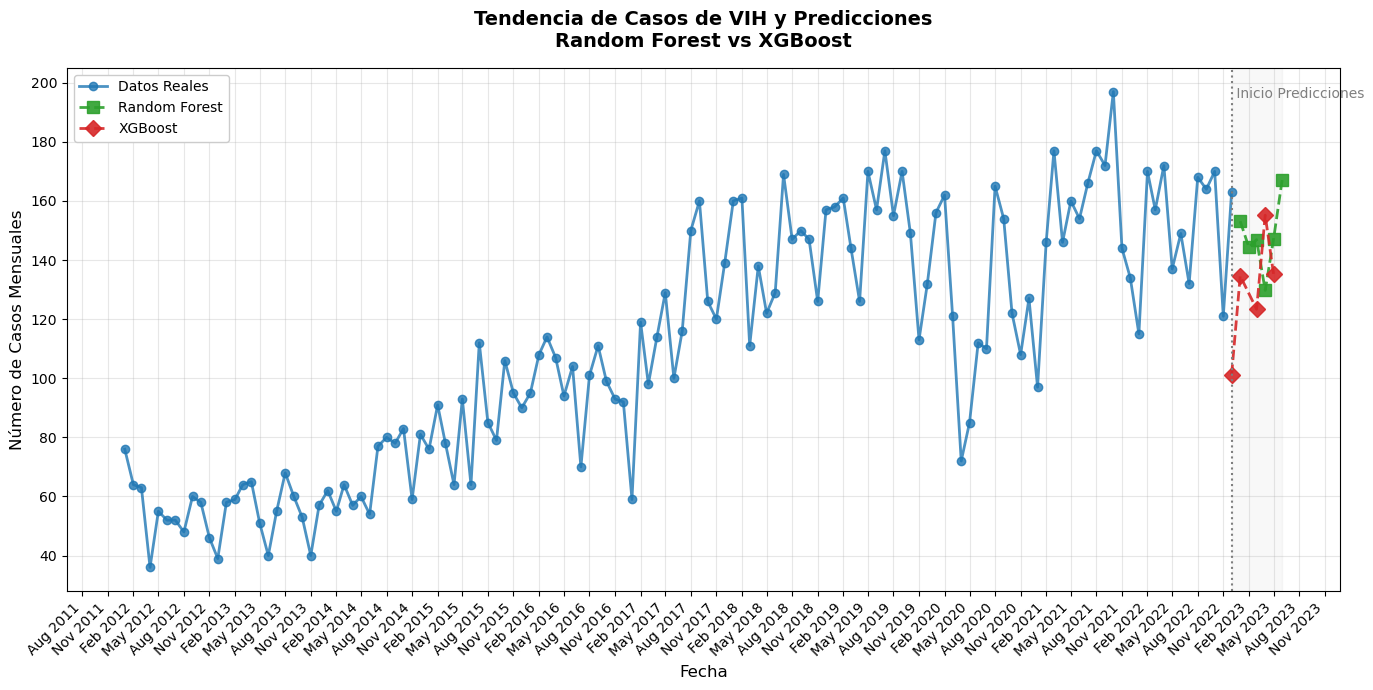


Resumen de Datos:
Últimos 5 valores reales:
            Casos
Fecha            
2022-08-01    168
2022-09-01    164
2022-10-01    170
2022-11-01    121
2022-12-01    163

Predicciones Random Forest:
            Random Forest
Fecha                    
2023-01-01         153.15
2023-02-01         144.35
2023-03-01         146.92
2023-04-01         129.74
2023-05-01         146.99
2023-06-01         167.08

Predicciones XGBoost:
            XGBoost
Fecha              
2022-12-01   101.23
2023-01-01   134.65
2023-03-01   123.37
2023-04-01   155.18
2023-05-01   135.32


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# 1. Cargar tus datos reales
print("\nCargando y procesando datos...")
monthly_cases = pd.read_excel('DATASET_VIH_LIMPIO_20250508_1728.xlsx', 
                             sheet_name='Datos VIH',
                             parse_dates=['Fecha'])
monthly_cases = monthly_cases.set_index('Fecha').resample('MS').size().to_frame('Casos')

# 2. Preparar las predicciones (tus datos proporcionados)
# Random Forest
rf_predictions = pd.DataFrame({
    'Fecha': pd.to_datetime(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01']),
    'Random Forest': [153.15, 144.35, 146.92, 129.74, 146.99, 167.08]
}).set_index('Fecha')

# XGBoost (nota: hay dos predicciones para marzo 2023, asumiré que es un error y tomaré valores únicos)
xgb_predictions = pd.DataFrame({
    'Fecha': pd.to_datetime(['2022-12-01', '2023-01-01', '2023-03-01', '2023-04-01', '2023-05-01']),
    'XGBoost': [101.23, 134.65, 123.37, 155.18, 135.32]  # Eliminado duplicado para marzo
}).set_index('Fecha')

# 3. Configuración profesional del gráfico
plt.figure(figsize=(14, 7))
plt.style.use('default')  # Estilo base para máxima compatibilidad

# Configuración manual de estilos
plt.rcParams.update({
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# 4. Graficar datos reales
plt.plot(monthly_cases.index, monthly_cases['Casos'], 
         'o-', color='#1f77b4', linewidth=2, markersize=6,
         label='Datos Reales', alpha=0.8)

# 5. Graficar predicciones
# Random Forest
plt.plot(rf_predictions.index, rf_predictions['Random Forest'], 
         's--', color='#2ca02c', linewidth=2, markersize=8,
         label='Random Forest', alpha=0.9)

# XGBoost
plt.plot(xgb_predictions.index, xgb_predictions['XGBoost'], 
         'D--', color='#d62728', linewidth=2, markersize=8,
         label='XGBoost', alpha=0.9)

# 6. Línea vertical para inicio de predicciones
pred_start = min(rf_predictions.index.min(), xgb_predictions.index.min())
plt.axvline(x=pred_start, color='#7f7f7f', linestyle=':', linewidth=1.5)
plt.text(pred_start, plt.ylim()[1]*0.95, ' Inicio Predicciones', 
         fontsize=10, color='#7f7f7f', ha='left')

# 7. Formatear ejes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')

# 8. Área de predicción
plt.axvspan(pred_start, max(rf_predictions.index.max(), xgb_predictions.index.max()), 
            alpha=0.05, color='grey')

# 9. Detalles finales
plt.title('Tendencia de Casos de VIH y Predicciones\nRandom Forest vs XGBoost', 
          fontsize=14, pad=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Casos Mensuales', fontsize=12)
plt.legend(fontsize=10, framealpha=1)

# 10. Ajustar layout y mostrar
plt.tight_layout()
plt.show()

# 11. Versión resumida de los datos mostrados
print("\nResumen de Datos:")
print("Últimos 5 valores reales:")
print(monthly_cases.tail())
print("\nPredicciones Random Forest:")
print(rf_predictions)
print("\nPredicciones XGBoost:")
print(xgb_predictions)